In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from datetime import datetime

In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [3]:
# DEEP Q-LEARNING NETWORK CLASS

class DQN(nn.Module):
    def __init__(self, num_states_available): 
        super().__init__()
        self.fc1 = nn.Linear(in_features=num_states_available, out_features=36)   
        self.fc2 = nn.Linear(in_features=36, out_features=36)
        self.out = nn.Linear(in_features=36, out_features=4)
        
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

In [4]:
# EXPERIENCE CLASS

Experience = namedtuple('Experience', ['state', 'action', 'next_state', 'reward', 'done'])

In [5]:
# MEMORY CONTAINER CLASS

class MemoryContainer():
    def __init__(self, capacity, datatype):
        self.capacity = capacity
        self.datatype = datatype
        self.array = np.zeros(capacity, dtype=datatype)
        self.sum = 0
        self.max = 1
        self.push_count = 0
        
    def push(self, element):
        next_location = self.push_count % self.capacity
        if self.datatype != Experience:
            self.sum -= self.array[next_location]
            self.sum += element
        self.array[next_location] = element
        self.push_count += 1
            
    def get_max(self):
        return self.max
    
    def get_sum(self):
        return self.sum
    
    def get_len(self):
        if self.push_count < self.capacity:
            return self.push_count
        else:
            return self.capacity
    
    def get_recent(self):
        return self.array[(self.push_count-1) % self.capacity]
    
    def get_array(self):
        return self.array
    
    def update_array(self, index, value):
        self.array[index] = value
    
    def update_max(self, new_max):
        if new_max > self.max:
            self.max = new_max
            
    def update_sum(self, new_sum):
        self.sum = new_sum

In [6]:
# REPLAY MEMORY CLASS

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = MemoryContainer(capacity, Experience)
        self.priorities = MemoryContainer(capacity, np.float32)
        self.range = MemoryContainer(capacity, int)
        self.range_count = 0
        self.sample_indices = []
    
    def push(self, experience):
        self.memory.push(experience)
        if self.range_count < self.capacity:
            self.range.push(self.range_count)
            self.range_count += 1
        self.priorities.push(self.priorities.get_max())
        
    def sample(self, batch_size, bias=1.0):
        self.sample_indices = random.choices(self.range.get_array(), k=batch_size, \
                                             weights=self.priorities.get_array())
        self.sample_batch = self.memory.get_array()[self.sample_indices]
        self.importance = (self.priorities.get_sum() / self.memory.get_len() \
                            / self.priorities.get_array()[self.sample_indices]) ** bias
        return self.sample_batch, torch.tensor(self.importance)
    
    def update_priorities(self, error_squared, offset=0.1):
        self.new_sum = self.priorities.get_sum()
        for i, j in zip(self.sample_indices, range(len(error_squared))):
            self.new_sum -= self.priorities.get_array()[i]
            self.priorities.update_array(i, error_squared[j] + offset)
            self.new_sum += self.priorities.get_array()[i]
        self.priorities.update_sum(self.new_sum)
        self.priorities.update_max(max(error_squared))

    def can_provide_sample(self, batch_size):
        return self.memory.get_len() >= batch_size

In [7]:
# LINEAR GROWTH CLASS

class Linear():
    def __init__(self, start, end, steps):
        self.rate = (end - start) / steps
        self.start = start + self.rate
        self.end = end
        
    def get_value(self):
        if self.start > self.end:
            return self.end
        else:
            self.temp = self.start
            self.start += self.rate
            return self.temp

In [8]:
# EPSILON GREEDY STRATEGY CLASS

class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

In [9]:
# AGENT CLASS

class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device)
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device)

In [10]:
# ENVIRONMENT CLASS

class LunarLanderEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('LunarLander-v2').unwrapped
        self.current_state = self.env.reset()
        self.done = False
        
    def reset(self):
        self.current_state = self.env.reset()
    
    def close(self):
        self.env.close()
    
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        self.current_state, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_state is None
    
    def get_state(self):
        self.current_state = torch.from_numpy(self.current_state)
        return self.current_state.unsqueeze(0).to(self.device)
    
    def num_states_available(self):
        return self.env.observation_space.shape[0]
    
    def if_done(self):
        return torch.tensor(int(self.done)).unsqueeze(-1).to(device)

In [11]:
# TRAINING PERFORMANCE PLOTS

def plot(episode_rewards, moving_avg_period, current_step, eps_decay, losses):
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.title('Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(episode_rewards)
    moving_avg = get_moving_average(moving_avg_period, episode_rewards)
    plt.plot(moving_avg)

    plt.subplot(1,2,2)
    plt.title('Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.plot(losses)
    plt.pause(0.001)
    
    print("Episode", len(episode_rewards), "\t", moving_avg_period, "Episodes average reward:", moving_avg[-1])
    print("Steps", current_step, \
        "\tExploring probability", math.exp(-1. * current_step * eps_decay))
    print("Average loss:\t", np.mean(losses))
    
    if is_ipython: display.clear_output(wait=True)
    
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
        
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [12]:
# TENSOR PROCESSING FUNCTION

def extract_tensors(expriences):
    batch = Experience(*zip(*experiences))
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    t5 = torch.cat(batch.done)
    return (t1, t2, t3, t4, t5)

In [13]:
# Q-VALUE CALCULATOR CLASS

class QValues():
    device = torch.device("cuda")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        return target_net(next_states).max(dim=1)[0]

In [14]:
a = torch.tensor([[-100, 100, -5, 5]])
a.multiply(0.02).exp().sub(1)

tensor([[-0.8647,  6.3891, -0.0952,  0.1052]])

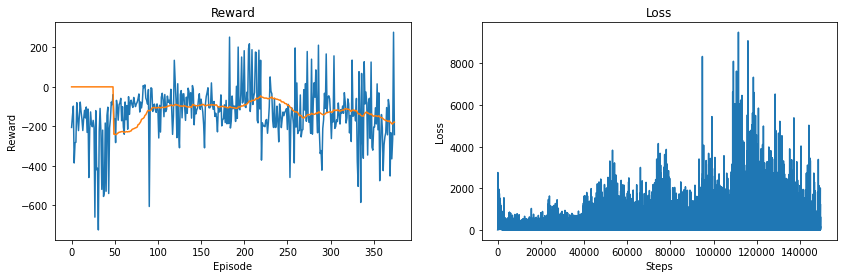

Episode 375 	 50 Episodes average reward: -178.7971
Steps 149514 	Exploring probability 1.1665271005986594e-65
Average loss:	 143.85602662916176


In [ ]:
# MAIN PROGRAM ==============================================================

# HYPERPARAMETERS ===========================================================

batch_size = 32
gamma = 0.99
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
alpha_start = 0.3
alpha_end = 0.3
alpha_steps = 30000
bias_start = 0
bias_end = 1
bias_steps = 50000
target_update = 500
memory_size = 30000
lr = 0.001
num_episodes = 3000

# OBJECT INSTANCES ===========================================================

device = torch.device("cuda")
em = LunarLanderEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
alpha = Linear(alpha_start, alpha_end, alpha_steps)
bias = Linear(bias_start, bias_end, bias_steps)

agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.num_states_available()).to(device)
target_net = DQN(em.num_states_available()).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

# MAIN LOOP =================================================================

episode_rewards = []
losses = []

for episode in range (num_episodes):
    em.reset()
    state = em.get_state()
    total_reward = 0
    
    for timestep in count():
        
#         em.render()
        
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        done = em.if_done()
        memory.push(Experience(state, action, next_state, reward, done))
        state = next_state
        total_reward += reward.item()
    
        if memory.can_provide_sample(batch_size):
            experiences, importance = memory.sample(batch_size, bias.get_value())
            states, actions, rewards, next_states, dones = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            current_q_values = current_q_values.float()

            next_q_values = QValues.get_next(target_net, next_states)
            next_q_values = next_q_values.float()

            target_q_values = (next_q_values * gamma) * (1 - dones) + rewards
            target_q_values = target_q_values.float()

            error = current_q_values - target_q_values.unsqueeze(1)
            loss = torch.mean(torch.square(torch.multiply(error, importance.to(device))))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            memory.update_priorities(error.detach().flatten().square().pow(alpha.get_value()).cpu().numpy())
            losses.append(loss.item())
            
            if agent.current_step % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())
        
        if em.done or timestep == 2000:
            episode_rewards.append(total_reward)
            plot(episode_rewards, 50, agent.current_step, eps_decay, losses)
            total_reward = 0
            break
        
#     if episode % target_update == 0:
#         target_net.load_state_dict(policy_net.state_dict())
        
em.close()
date_time = datetime.now().strftime("%y/%m/%d_%H:%M:%S")
FILE = "model_" + date_time + ".pth"
torch.save(policy_net, FILE)

In [ ]:
'''
Observatons

Experience Replay:

    Memory capacity too high:
        Old experiences don't get overwritten, new experiences only take up
        a small portion of the memory pool. New experiences become less likely to be sampled.
    Memory capacity too low:
        Experiences become highly correlated
    Memory capacity just right:
        Enough memory space to contain unrelated experiences, while old experiences get cycled out
        frequently enough
        
    High sampling size:
        Each experience in the memory gets higher chance of being sampled and used to train the NN,
        but at the cost of a higher computational power.
    Low sampling size:
        Each experience in the memory gets lower chance of being sampled and used to train the NN,
        but is easier to compute.
        
    Potential improvements:
        1. Prioritized experience replay
            Some rare but important occasions should get higher chance of being used for training
            
Target Network:

    Early training:
        (?) Higher target update period might benefit learning
        
    Late training:
        (?) High target update period might be bad for learning
        
Interesting behaviors:

na 8/36/36/4, gma 0.999, eps 0.001, mem 512/10000, tn 5, lr 0.001

    The agent first learns to balance itself, then stay stay afloat. This phase takes a long time because
    the lander sometimes hovers almost indefinitely. It then learns to move downwards to land on the
    ground. Finally it learns to land faster, and learns to handle rare situations.
    
    At 800+ episodes, agent learns to land harder in such a way that it doesn't crash,
    rather than landing too carfully, this helps it to save fuel.
    
    During mid-phase the agent perfected its landing by always moving to the left, then slowly close
    in on the landing pad. Whenever it starts from the right, it doesn't know how to land and crashes.
    Over time, it learns to land from the right. The learning is asymmetric, both left and right has to
    be learned independently, it cannot learn by mirroring the other side. This shows that although AI
    can learn complex behaviours, they do not understand the higher context of its surroundings.
    
    At ~900 episodes, the agent has already near-perfect landing, but when the training keeps going,
    it slowly gets worse.
    
    
na 8/24/24/4, gma 0.999, eps 0.001, mem 512/10000, tn 5, lr 0.001
    
    Agent might learn to fly indefinitely. Neural network becomes over-trained for that specific episode, 
    which causes subsequent episodes to fail.
    
na 8/24/24/4, gma 0.999, eps 0.001, mem 512/10000, tn 5, lr 0.004

    Agent learns too slow. Still haven't learnt to fly properly at 82 episodes. Gets indefinite flying
    at episode 82.
    
na 8/24/24/4, gma 0.999, eps 0.001, mem 512/10000, tn 5, lr 0.002

    Agents learns faster than previous iteration, Gets indefinite flying at episode 17.

'''